## Incremental Deep Learning for Image Classification

This notebook implements an incremental learning approach for image classification using deep learning. The idea is to train a deep learning model on a small dataset and then incrementally train the model on new data.

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Pipeline](#data-pipeline)
3. [Model Architecture](#model-architecture)
4. [Training Pipeline](#training)
5. [Evaluation](#evaluation)
6. [Results](#results)


### 1. Setup and Imports <a id='setup'></a>

Configures logging and import required libraries


In [181]:
import json
import logging
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#### Configuration


In [182]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [183]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [184]:
tf.random.set_seed(42)
np.random.seed(42)

##### Visualization


In [185]:
sns.set_theme(style="whitegrid")

## 2. Data Pipeline <a id='data-pipeline'></a>


Configures the data split object


In [186]:
@dataclass
class DataSplit:
    train_paths: List[str]
    val_paths: List[str]
    test_paths: List[str]
    class_mapping: Dict[str, int]
    num_classes: int

### Data Manager


In [187]:
class DataManager:
    def __init__(
        self,
        base_path: str,
        img_size: Tuple[int, int] = (224, 224),
        val_split: float = 0.15,
        test_split: float = 0.15,
        random_seed: int = 42,
    ):
        self.data_dir = Path(base_path)
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split

        self.seed = random_seed
        self.class_counts = self._get_class_counts()
        self.sorted_classes = self._sort_classes_by_size()
        self.class_mapping = self._create_class_mapping()

    def _get_class_counts(self) -> Dict[str, int]:
        """
        Counts the number of images in each class directory.
        """

        class_counts: dict = {}
        if not self.data_dir.exists():
            raise ValueError(f"Data directory {self.data_dir} does not exist.")

        for class_dir in self.data_dir.iterdir():
            if class_dir.is_dir():
                class_counts[class_dir.name] = len(list(class_dir.glob("*.jpg")))

        return class_counts

    def _sort_classes_by_size(self) -> List[str]:
        """
        Sorts the classes by the number of images in each class.

        Returns:
          List[str]: List of class names sorted by the number of images in each class.
        """

        return sorted(
            self.class_counts.keys(),
            key=lambda x: (self.class_counts[x], int(x)),
            reverse=True,
        )

    def _create_class_mapping(self) -> Dict[str, int]:
        """
        Creates a mapping from class names to class indices.

        Returns:
          Dict[str, int]: Dictionary mapping class names to class indices.
        """

        return {class_name: int(class_name) for class_name in self.class_counts.keys()}

    def get_class_subset(self, num_classes: int) -> List[str]:
        """
        Gets the top `num_classes` classes sorted by the number of images in each class.

        Args:
          num_classes (int): Number of classes to include in the dataset.

        Returns:
          List[str]: List of class names.
        """

        if num_classes > len(self.sorted_classes):
            raise ValueError(
                f"Requested {num_classes} classes, but only {len(self.sorted_classes)} available."
            )

        return self.sorted_classes[:num_classes]

    def _collect_image_paths(self, classes: List[str]) -> Tuple[List[str], List[str]]:
        """
        Collects all image paths and their corresponding labels for the
        given classes.

        Args:
          classes (List[str]): List of class names to include in the dataset.

        Returns:
          Tuple[List[str], List[str]]: Tuple containing the image paths and their corresponding labels.
        """

        image_paths, labels = [], []

        for class_name in classes:
            class_path = self.data_dir / class_name

            if not class_path.exists():
                logger.warning(f"Class directory {class_path} does not exist.")
                continue

            image_files = []
            for ext in ["*.jpg"]:
                image_files.extend(list(class_path.glob(ext)))

            if not image_files:
                logger.warning(f"No images found in {class_path}")
                continue

            image_paths.extend([str(img) for img in image_files])
            labels.extend([class_name] * len(image_files))

            logger.info(f"Collected {len(image_files)} images for class {class_name}")

            if not image_paths:
                raise ValueError(f"No images found for classes {classes}")

        return image_paths, labels

    def prepare_data_split(self, classes: List[str]) -> DataSplit:
        """
        Prepares the data split for the given classes. It first
        divides the data into train_val and test sets, and then
        further divides the train_val set into train and validation

        Args:
            classes (List[str]): List of class names to include in the dataset.

        Returns:
            DataSplit: DataSplit object containing the train, validation, and test splits.
        """

        image_paths, labels = self._collect_image_paths(classes)
        subset_mapping = {cls: self.class_mapping[cls] for cls in classes}

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            image_paths,
            labels,
            test_size=self.test_split,
            stratify=labels,
            random_state=self.seed,
        )

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths,
            train_val_labels,
            test_size=self.val_split / (1 - self.test_split),
            stratify=train_val_labels,
            random_state=self.seed,
        )

        logger.info(
            f"Split sizes - Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}"
        )

        return DataSplit(
            train_paths=train_paths,
            val_paths=val_paths,
            test_paths=test_paths,
            class_mapping=subset_mapping,
            num_classes=len(classes),
        )

    def plot_class_distribution(self, classes: Optional[List[str]] = None):
        """
        Plots the class distribution for the given classes.

        Args:
            clases (Optional[List[str]]): List of class names to include in the plot.
        """

        if classes is None:
            classes = self.sorted_classes

        counts = [self.class_counts[cls] for cls in classes]
        plt.figure(figsize=(12, 6))
        plt.bar(classes, counts)
        plt.title("Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Data Generator


In [188]:
class DataGenerator:
    def __init__(self, img_size: Tuple[int, int], batch_size: int = 32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_datagen = self._create_train_datagen()
        self.test_datagen = self._create_test_datagen()
        self.label_to_index = None
        self.num_classes = None

    def _create_train_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the training data generator with data augmentation. The following augmentations are applied:
        - Rotation
        - Width and height shift
        - Shear
        - Zoom
        - Horizontal and vertical flip
        - Brightness

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Training data generator.
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="constant",
            brightness_range=(0.6, 1.4),
            channel_shift_range=0.2,
        )

    def _create_test_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the test data generator with only the input preprocessing function.

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Test data generator
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self._preprocess_input,
        )

    def _preprocess_input(self, x):
        """
        Preprocesses the input image by scaling pixel values to the range of [-1, 1].

        Args:
            x (np.ndarray): Input image.

        Returns:
            np.ndarray: Preprocessed image.
        """

        x = tf.cast(x, tf.float32)

        return tf.image.per_image_standardization(x)

    def create_generators(self, data_split: DataSplit):
        """
        Creates the generators for training, validation, and testing.

        Args:
            data_split (DataSplit): DataSplit object containing the train, validation, and test splits.

        Returns:
            Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]: Tuple containing the training, validation, and test datasets.
        """

        self.label_to_index = data_split.class_mapping
        self.num_classes = data_split.num_classes

        def create_df(paths: List[str]) -> pd.DataFrame:
            return pd.DataFrame(
                {
                    "filename": paths,
                    "class": [Path(p).parent.name for p in paths],
                }
            )

        train_df = create_df(data_split.train_paths)
        val_df = create_df(data_split.val_paths)
        test_df = create_df(data_split.test_paths)

        logger.info(
            f"Training set class distribution:\n{train_df['class'].value_counts()}"
        )

        train_ds = self._create_dataset(train_df, is_training=True)
        val_ds = self._create_dataset(val_df, is_training=False)
        test_ds = self._create_dataset(test_df, is_training=False)

        return train_ds, val_ds, test_ds

    def _create_dataset(
        self, df: pd.DataFrame, is_training: bool = False
    ) -> tf.data.Dataset:
        """
        Creates the tf.data.Dataset object from the given DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing the image paths and their corresponding labels.
            is_training (bool): Whether the dataset is for training or not.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        datagen = self.train_datagen if is_training else self.test_datagen
        filenames = df["filename"].values
        labels = df["class"].map(self.label_to_index).values

        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(self.batch_size)

        if is_training:
            dataset = dataset.shuffle(
                buffer_size=len(df), reshuffle_each_iteration=True
            )

        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        steps = len(df) // self.batch_size
        if is_training:
            self.steps_per_epoch = steps

        else:
            self.validation_steps = steps

        return dataset

    @tf.function
    def _parse_function(self, filename, label):
        """
        Loads and preprocesses the image and its corresponding label.

        Args:
            filename (tf.Tensor): Image filename.
            label (tf.Tensor): Image label.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: Tuple containing the image and its label
        """

        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.img_size)
        label = tf.one_hot(label, self.num_classes)

        return image, label

    def get_steps(self):
        return self.steps_per_epoch, self.validation_steps

    def get_num_classes(self):
        return self.num_classes

    def get_class_mapping(self):
        return self.label_to_index

## Pre-Trained Model


In [189]:
import keras

In [190]:
f1_score_metric = tf.keras.metrics.F1Score(
    average="macro", threshold=None, name="f1_score"
)


@keras.saving.register_keras_serializable()
def sparse_f1_score(y_true, y_pred):
    return f1_score_metric(y_true, y_pred)

In [191]:
@keras.saving.register_keras_serializable()
class ModelManager:
    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        model_dir: str = "models",
        initial_lr: float = 1e-4,
    ):
        self.img_size = img_size
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.initial_lr = initial_lr
        self.model = None
        self.base_model = None

    def build_model(self, num_classes: int) -> tf.keras.Model:
        if self.model is None:
            self.base_model = tf.keras.applications.MobileNetV3Large(
                weights="imagenet", include_top=False, input_shape=(*self.img_size, 3)
            )

            self.base_model.trainable = False

            inputs = tf.keras.Input(shape=(*self.img_size, 3))
            x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)

            x = self.base_model(x, training=False)
            x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
            x2 = tf.keras.layers.GlobalMaxPooling2D()(x)

            x = tf.keras.layers.Concatenate()([x1, x2])
            x = tf.keras.layers.Dense(512, use_bias=False)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Dropout(0.5)(x)

            x = tf.keras.layers.Dense(256, activation="relu")(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

            self.model = tf.keras.Model(inputs, outputs)

        self.current_classes = num_classes
        self._compile_model(num_classes=num_classes)
        return self.model

    def _compile_model(self, num_classes):
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.initial_lr, clipnorm=1.0
        )

        self.model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=["accuracy", sparse_f1_score],
        )

    def train(
        self,
        train_ds,
        val_ds,
        iteration: int,
        epochs: int = 50,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                str(self.model_dir / f"best_model_iter_{iteration}.keras"),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                restore_best_weights=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
            ),
        ]

        history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
        )

        self.model.save(str(self.model_dir / f"model_iter_{iteration}.keras"))

        return history

    def prepare_next_iteration(
        self, previous_iteration: int, new_num_classes: int
    ) -> None:
        self.load_best_model(f"{previous_iteration}")
        self.current_classes = new_num_classes

        old_weights = [layer.get_weights() for layer in self.model.layers[:-1]]
        old_output_layer = self.model.layers[-1]

        self.build_model(new_num_classes)

        for layer, weights in zip(self.model.layers[:-1], old_weights):
            if weights:
                layer.set_weights(weights)

    def load_best_model(self, iteration: str) -> None:
        model_path = self.model_dir / f"best_model_iter_{iteration}.keras"
        if not model_path.exists():
            raise ValueError(f"No saved model found for iteration {iteration}")

        self.model = tf.keras.models.load_model(
            str(model_path), custom_objects={"sparse_f1_score": self.sparse_f1_score}
        )
        logger.info(f"Loaded best model from iteration {iteration}")

    def save_iteration_info(self, iteration: int, metrics: Dict) -> None:
        info = {
            "iteration": iteration,
            "metrics": metrics,
            "model_config": self.model.get_config(),
            "timestamp": datetime.now().isoformat(),
        }

        with open(self.model_dir / f"iteration_{iteration}_info.json", "w") as f:
            json.dump(info, f, indent=4)

    def get_config(self) -> Dict:
        return self.model.get_config()

### Auxiliary function


In [192]:
def plot_history_subplot(history):
    """Plot training history metrics."""
    fig = plt.figure(figsize=(15, 5))

    # Accuracy subplot
    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(history.history["accuracy"], label="Training")
    ax1.plot(history.history["val_accuracy"], label="Validation")
    ax1.set_title("Model Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True)

    # Loss subplot
    ax2 = plt.subplot(1, 3, 2)
    ax2.plot(history.history["loss"], label="Training")
    ax2.plot(history.history["val_loss"], label="Validation")
    ax2.set_title("Model Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    # F1 Score subplot
    ax3 = plt.subplot(1, 3, 3)
    ax3.plot(history.history["sparse_f1_score"], label="Training")
    ax3.plot(history.history["val_sparse_f1_score"], label="Validation")
    ax3.set_title("Model F1 Score")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("F1 Score")
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [193]:
from collections import Counter

In [194]:
class ModelEvaluator:
    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager
        self.evaluation_history: Dict[int, Dict] = {}

    def evaluate_iteration(
        self,
        iteration: int,
        test_ds: tf.data.Dataset,
        class_names: List[str],
        plot: bool = True,
    ) -> Dict:
        y_pred = []
        y_true = []

        for images, labels in test_ds:
            predictions = self.model_manager.model.predict(images, verbose=0)
            y_pred.extend(np.argmax(predictions, axis=1))
            y_true.extend(np.argmax(labels, axis=1))

        labels = range(len(class_names))

        cm = confusion_matrix(y_true, y_pred, labels=labels)
        report = classification_report(
            y_true,
            y_pred,
            labels=labels,
            target_names=class_names,
            output_dict=True,
            zero_division=0,
        )

        print("Test set distribution:", Counter(y_true))
        print("Prediction distribution:", Counter(y_pred))

        results = {
            "confusion_matrix": cm,
            "classification_report": report,
            "class_names": class_names,
        }

        self.evaluation_history[iteration] = results
        if plot:
            self.plot_confusion_matrix(iteration)

        return results

    def plot_confusion_matrix(
        self, iteration: int, figsize: Tuple[int, int] = (20, 8), cmap: str = "Blues"
    ) -> None:
        """
        Plots normalized and raw confusion matrices side by side.
        """
        if iteration not in self.evaluation_history:
            raise ValueError(f"No evaluation data found for iteration {iteration}")

        results = self.evaluation_history[iteration]
        cm = results["confusion_matrix"]
        class_names = results["class_names"]

        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot normalized confusion matrix
        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax1,
        )
        ax1.set_title(f"Normalized Confusion Matrix - Iteration {iteration}")
        ax1.set_ylabel("True Label")
        ax1.set_xlabel("Predicted Label")
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

        # Plot raw counts confusion matrix
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax2,
        )
        ax2.set_title(f"Raw Counts Confusion Matrix - Iteration {iteration}")
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        plt.show()

    def print_classification_report(self, iteration: int) -> None:
        """Prints the classification report for a given iteration."""
        if iteration not in self.evaluation_history:
            raise ValueError(f"No evaluation data found for iteration {iteration}")

        report = self.evaluation_history[iteration]["classification_report"]
        print(f"\nClassification Report - Iteration {iteration}")
        print("-" * 60)

        for class_name in report.keys():
            if class_name in ["accuracy", "macro avg", "weighted avg"]:
                continue
            metrics = report[class_name]
            print(
                f"{class_name::<15} Precision: {metrics['precision']:.3f}  "
                f"Recall: {metrics['recall']:.3f}  "
                f"F1-score: {metrics['f1-score']:.3f}"
            )

        print("-" * 60)
        print(f"Accuracy: {report['accuracy']:.3f}")
        print(f"F1-Score: {report['macro avg']['f1-score']:.3f}")
        print(f"Weighted F1-Score: {report['weighted avg']['f1-score']:.3f}")

In [195]:
def compare_iterations_performance(evaluator, iterations=[1, 2]):
    plt.figure(figsize=(15, 6))

    for iteration in iterations:
        if iteration in evaluator.evaluation_history:
            report = evaluator.evaluation_history[iteration]["classification_report"]
            classes = evaluator.evaluation_history[iteration]["class_names"]

            # Get F1 scores for each class
            f1_scores = [report[cls]["f1-score"] for cls in classes]

            plt.subplot(1, 2, 1)
            plt.plot(
                range(len(classes)),
                f1_scores,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("F1 Score")
            plt.title("F1 Score by Class")
            plt.legend()

            # Get accuracies
            accuracies = [report[cls]["precision"] for cls in classes]

            plt.subplot(1, 2, 2)
            plt.plot(
                range(len(classes)),
                accuracies,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("Precision")
            plt.title("Precision by Class")
            plt.legend()

    plt.tight_layout()
    plt.show()

## Main Execution


In [196]:
dataset_manager = DataManager(
    base_path="../../../data/extended/day/", img_size=(224, 224)
)
data_generator = DataGenerator(img_size=(224, 224), batch_size=32)
model_manager = ModelManager(img_size=(224, 224), model_dir="saved_models")

In [197]:
evaluator = ModelEvaluator(model_manager)

## First Execution


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


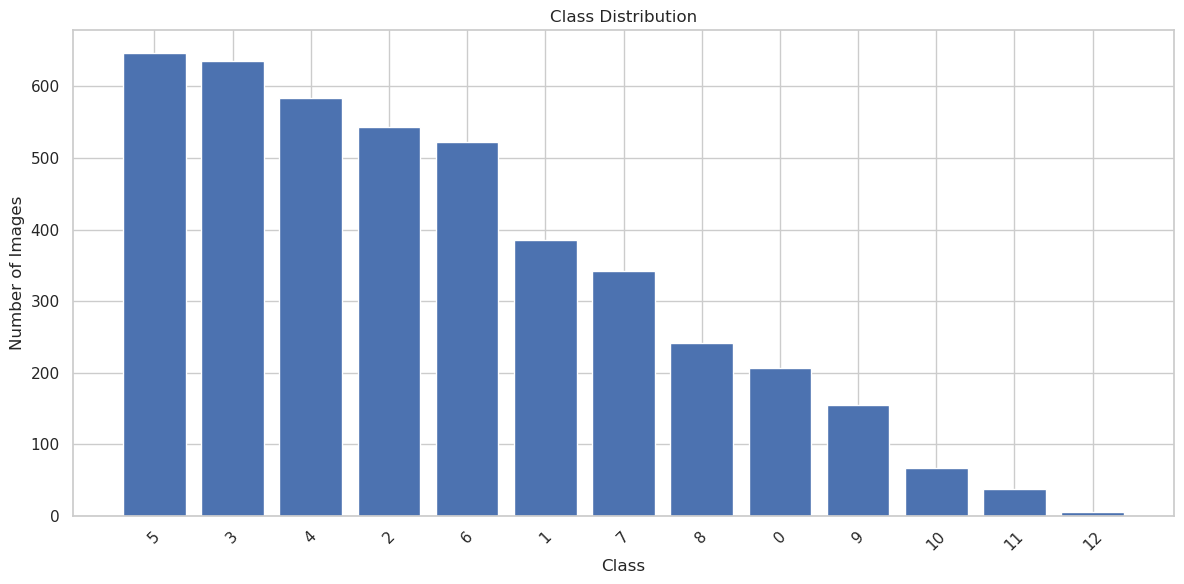

In [198]:
dataset_manager.plot_class_distribution()

### First Execution: Top 5 classes with highest probabilities


In [199]:
initial_classes = dataset_manager.get_class_subset(num_classes=7)
data_split = dataset_manager.prepare_data_split(initial_classes)

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Split sizes - Train: 2559, Val: 549, Test: 549


In [200]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
Name: count, dtype: int64


#### Calculating Class Weights


In [201]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in initial_classes)

class_weights = {
    data_split.class_mapping[cls]: total_samples
    / (len(initial_classes) * dataset_manager.class_counts[cls])
    for cls in initial_classes
}

In [202]:
steps_per_epoch, validation_steps = data_generator.get_steps()
logger.info(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

INFO:__main__:Steps per epoch: 79, Validation steps: 17


#### Initial Model


In [203]:
model = model_manager.build_model(data_generator.get_num_classes())
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 7, 7, 960) │  2,996,352 │ input_layer_11[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1920)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 512)       │    983,040 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_125      │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 512)       │          0 │ activation_125[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │    131,328 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 7)         │      1,799 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,114,567 (15.70 MB)

 Trainable params: 1,117,191 (4.26 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

In [204]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=1,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100


76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1652 - loss: 1.9960 - sparse_f1_score: 0.1069
Epoch 1: val_accuracy improved from -inf to 0.33515, saving model to saved_models/best_model_iter_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.1682 - loss: 1.9836 - sparse_f1_score: 0.1091 - val_accuracy: 0.3352 - val_loss: 1.4117 - val_sparse_f1_score: 0.2050 - learning_rate: 1.0000e-04
Epoch 2/100
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3271 - loss: 1.3673 - sparse_f1_score: 0.2255
Epoch 2: val_accuracy improved from 0.33515 to 0.37158, saving model to saved_models/best_model_iter_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3277 - loss: 1.3647 - sparse_f1_score: 0.2262 - val_accuracy: 0.3716 - val_loss: 1.1646 - val_sparse_f1_score: 0.2598 - learning_rate: 1.0000e-04
Epoch 3/100
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3754 - loss: 1.1680 - sparse_f1_score: 0.2698
Epoch 3: val_accuracy improved from 0.37158 to 0.42441, sav

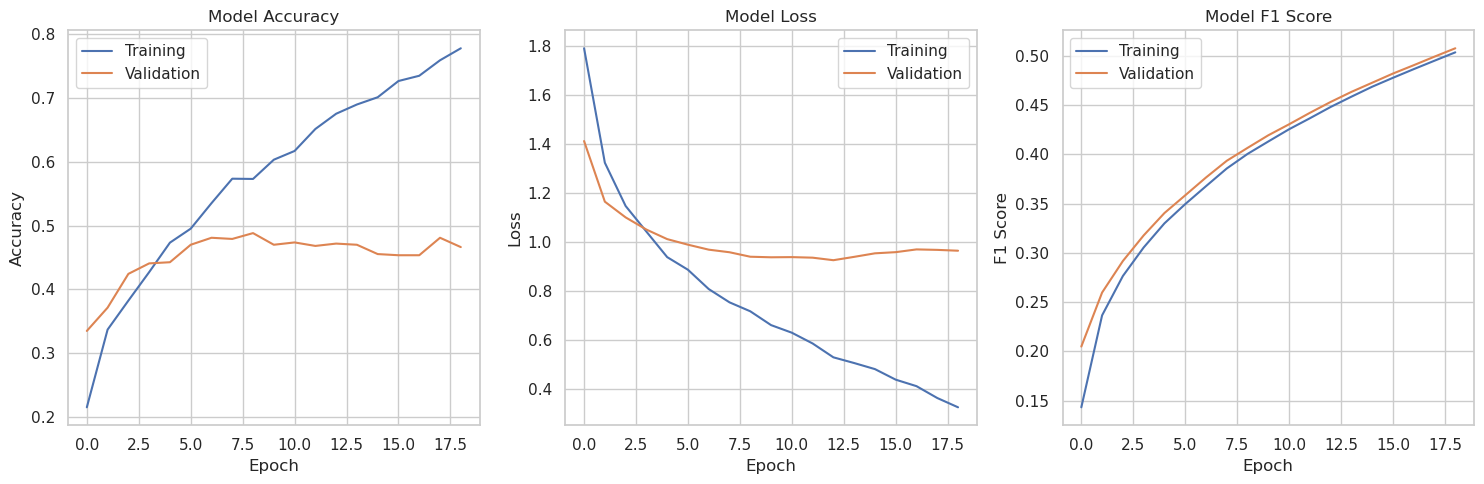

In [205]:
plot_history_subplot(history)

Test set distribution: Counter({5: 97, 3: 95, 4: 88, 2: 82, 6: 78, 1: 58, 0: 51})
Prediction distribution: Counter({6: 137, 5: 110, 3: 94, 4: 81, 2: 80, 1: 47})


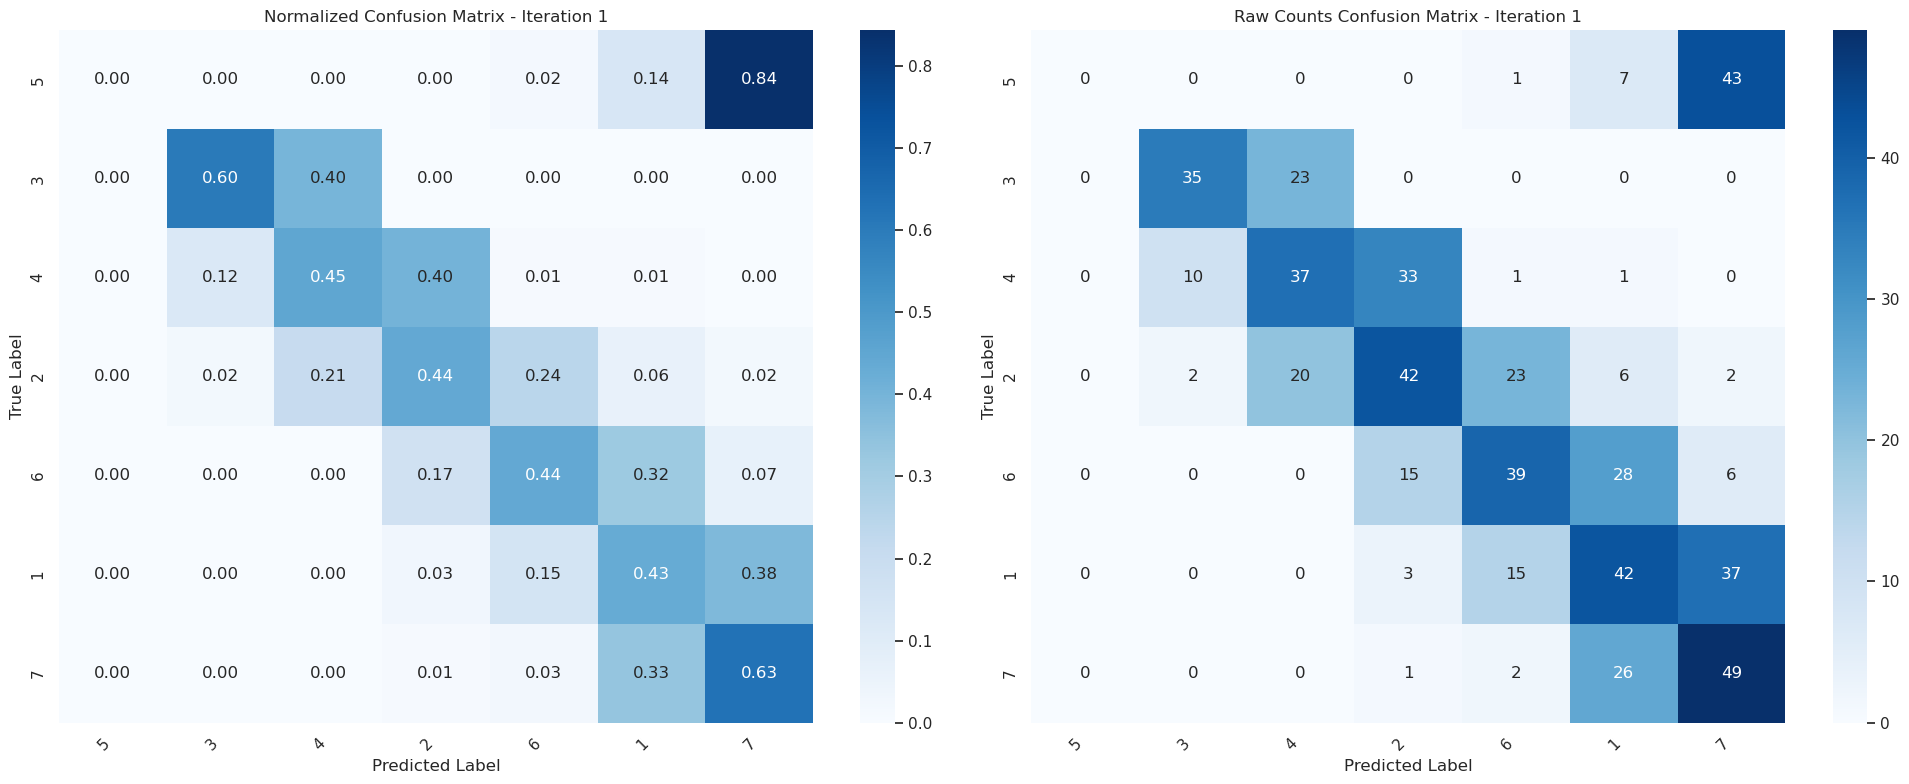

In [206]:
evaluation_results = evaluator.evaluate_iteration(
    iteration=1, test_ds=test_gen, class_names=initial_classes
)

In [207]:
evaluator.print_classification_report(iteration=1)


Classification Report - Iteration 1
------------------------------------------------------------
5:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
3:::::::::::::: Precision: 0.745  Recall: 0.603  F1-score: 0.667
4:::::::::::::: Precision: 0.463  Recall: 0.451  F1-score: 0.457
2:::::::::::::: Precision: 0.447  Recall: 0.442  F1-score: 0.444
6:::::::::::::: Precision: 0.481  Recall: 0.443  F1-score: 0.462
1:::::::::::::: Precision: 0.382  Recall: 0.433  F1-score: 0.406
7:::::::::::::: Precision: 0.358  Recall: 0.628  F1-score: 0.456
------------------------------------------------------------
Accuracy: 0.444
F1-Score: 0.413
Weighted F1-Score: 0.426


#### Second Iteration: The next classes with highest probabilities


In [208]:
all_classes = dataset_manager.get_class_subset(num_classes=9)
new_classes = all_classes[7:]

print(f"Original classes: {all_classes[:7]}")
print(f"New classes: {new_classes}")
print(f"All classes: {all_classes}")

Original classes: ['5', '3', '4', '2', '6', '1', '7']
New classes: ['8', '0']
All classes: ['5', '3', '4', '2', '6', '1', '7', '8', '0']


In [209]:
data_split = dataset_manager.prepare_data_split(all_classes)

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Collected 241 images for class 8
INFO:__main__:Collected 206 images for class 0
INFO:__main__:Split sizes - Train: 2872, Val: 616, Test: 616


In [210]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
8    169
0    144
Name: count, dtype: int64


In [211]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in all_classes)
max_count = max(dataset_manager.class_counts[cls] for cls in all_classes)

class_weights = {
    data_split.class_mapping[cls]: (total_samples / dataset_manager.class_counts[cls])
    * (max_count / dataset_manager.class_counts[cls])
    for cls in all_classes
}

print(class_weights)

{5: 6.352941176470588, 3: 6.57494946989894, 4: 7.773456558453744, 2: 8.991666921034158, 6: 9.729686880697582, 1: 17.88621352673301, 7: 22.666666666666664, 8: 45.64632151650281, 0: 62.47487981902158}


In [212]:
evaluator = ModelEvaluator(model_manager)

In [213]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=2,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100


87/90 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4556 - loss: 40.0841 - sparse_f1_score: 0.5064
Epoch 1: val_accuracy improved from -inf to 0.55519, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.4560 - loss: 39.6207 - sparse_f1_score: 0.5065 - val_accuracy: 0.5552 - val_loss: 0.8206 - val_sparse_f1_score: 0.5267 - learning_rate: 5.0000e-05
Epoch 2/100
87/90 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5033 - loss: 10.1664 - sparse_f1_score: 0.5530
Epoch 2: val_accuracy improved from 0.55519 to 0.58929, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5027 - loss: 10.1469 - sparse_f1_score: 0.5535 - val_accuracy: 0.5893 - val_loss: 0.7080 - val_sparse_f1_score: 0.5832 - learning_rate: 5.0000e-05
Epoch 3/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5215 - loss: 7.9271 - sparse_f1_score: 0.5906
Epoch 3: val_accuracy improved from 0.58929 to 0.60227,

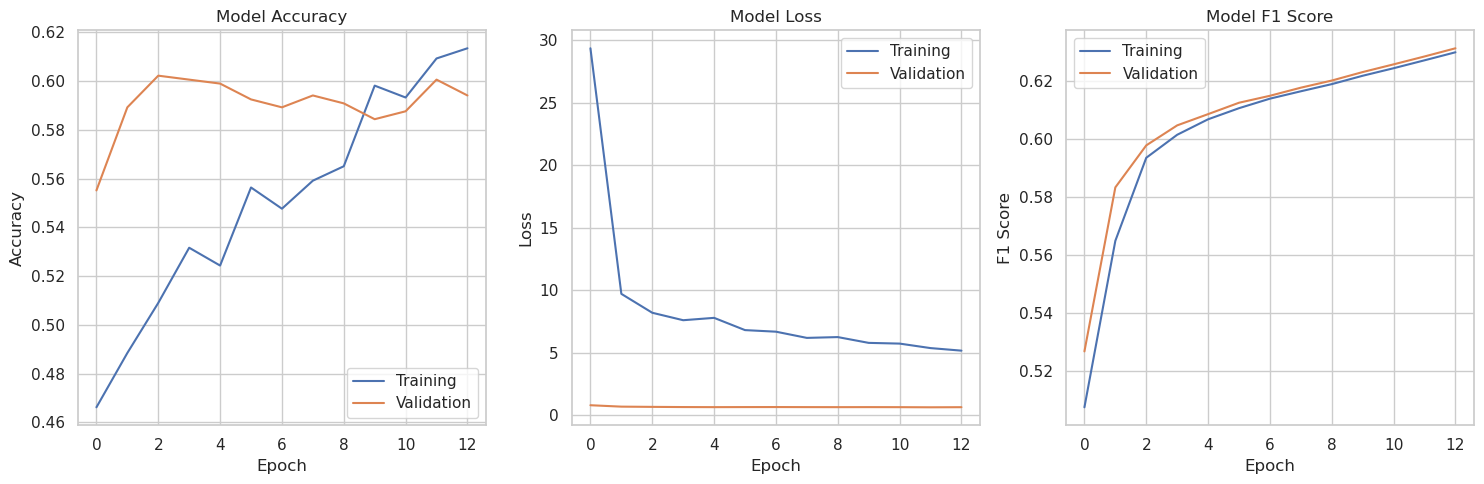

In [214]:
plot_history_subplot(history)

Test set distribution: Counter({0: 118, 5: 97, 3: 95, 4: 88, 2: 82, 6: 78, 1: 58})
Prediction distribution: Counter({6: 184, 3: 102, 5: 87, 2: 74, 4: 68, 1: 67, 0: 34})


/tmp/ipykernel_81362/937589467.py:65: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


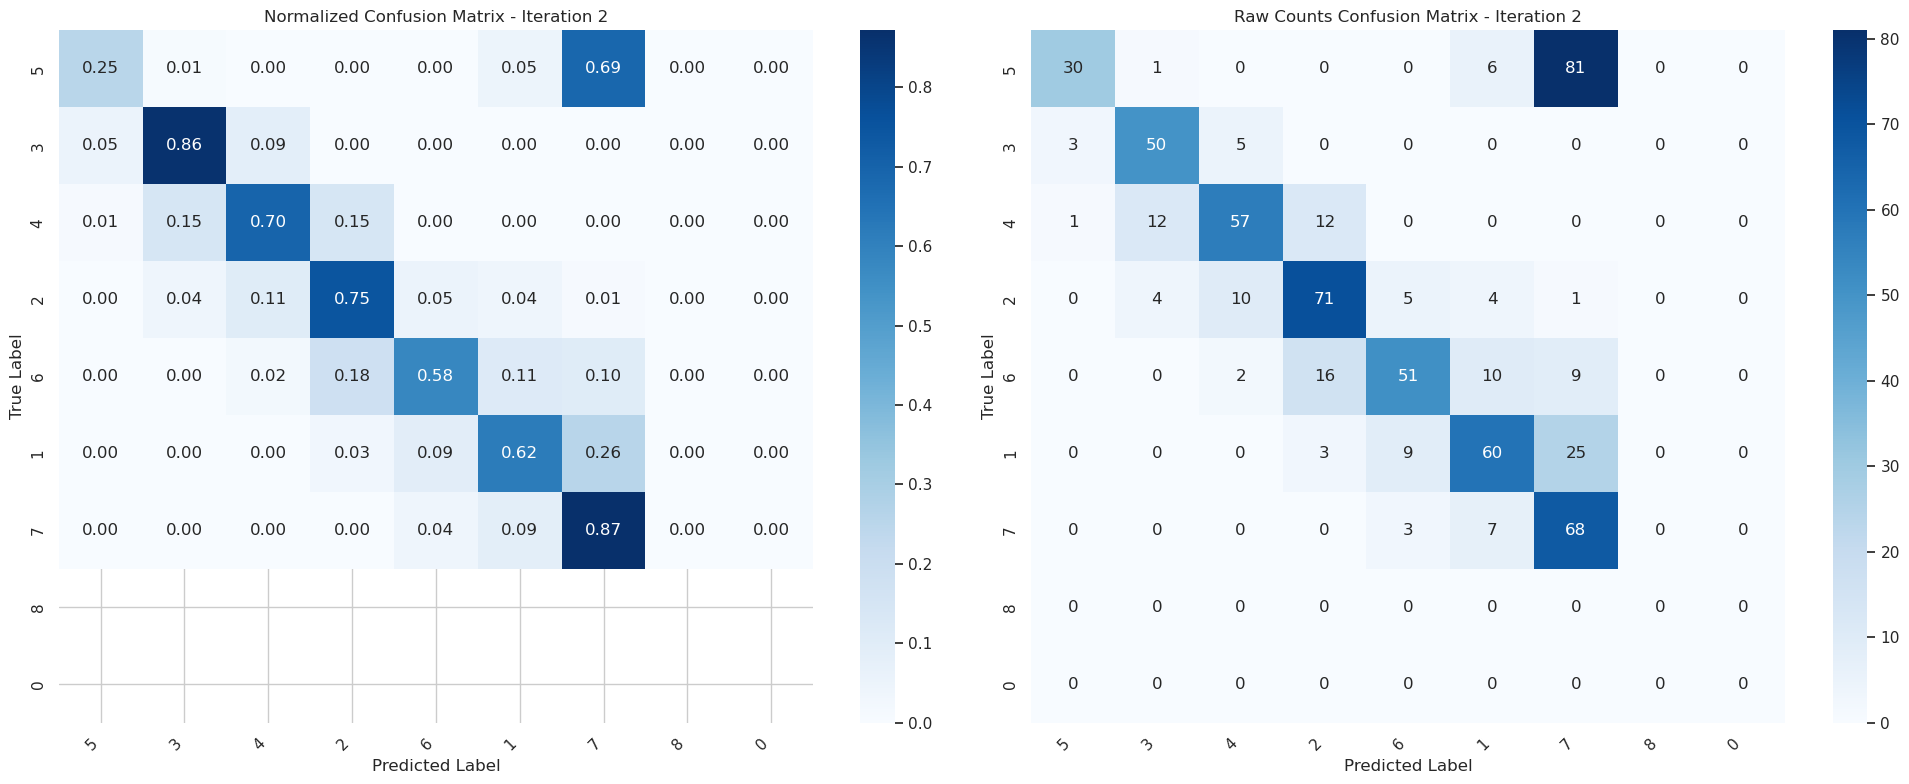

In [215]:
evaluation_results = evaluator.evaluate_iteration(
    iteration=2, test_ds=test_gen, class_names=all_classes
)

In [216]:
evaluator.print_classification_report(iteration=2)


Classification Report - Iteration 2
------------------------------------------------------------
5:::::::::::::: Precision: 0.882  Recall: 0.254  F1-score: 0.395
3:::::::::::::: Precision: 0.746  Recall: 0.862  F1-score: 0.800
4:::::::::::::: Precision: 0.770  Recall: 0.695  F1-score: 0.731
2:::::::::::::: Precision: 0.696  Recall: 0.747  F1-score: 0.721
6:::::::::::::: Precision: 0.750  Recall: 0.580  F1-score: 0.654
1:::::::::::::: Precision: 0.690  Recall: 0.619  F1-score: 0.652
7:::::::::::::: Precision: 0.370  Recall: 0.872  F1-score: 0.519
8:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
0:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
------------------------------------------------------------
Accuracy: 0.628
F1-Score: 0.497
Weighted F1-Score: 0.621


## Third Iteration


In [217]:
all_classes = dataset_manager.get_class_subset(num_classes=13)
new_classes = all_classes[9:]

print(f"Original classes: {all_classes[:7]}")
print(f"New classes: {new_classes}")
print(f"All classes: {all_classes}")

Original classes: ['5', '3', '4', '2', '6', '1', '7']
New classes: ['9', '10', '11', '12']
All classes: ['5', '3', '4', '2', '6', '1', '7', '8', '0', '9', '10', '11', '12']


In [218]:
data_split = dataset_manager.prepare_data_split(all_classes)

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Collected 241 images for class 8
INFO:__main__:Collected 206 images for class 0
INFO:__main__:Collected 155 images for class 9
INFO:__main__:Collected 67 images for class 10
INFO:__main__:Collected 37 images for class 11
INFO:__main__:Collected 5 images for class 12
INFO:__main__:Split sizes - Train: 3056, Val: 656, Test: 656


In [219]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
5     452
3     445
4     408
2     379
6     366
1     269
7     240
8     169
0     144
9     109
10     47
11     25
12      3
Name: count, dtype: int64


In [220]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in all_classes)
class_weights = {
    data_split.class_mapping[cls]: total_samples
    / (len(all_classes) * dataset_manager.class_counts[cls])
    for cls in all_classes
}

In [221]:
evaluator = ModelEvaluator(model_manager)

In [222]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=3,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4764 - loss: 0.4910 - sparse_f1_score: 0.6309
Epoch 1: val_accuracy improved from -inf to 0.60823, saving model to saved_models/best_model_iter_3.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.4764 - loss: 0.4911 - sparse_f1_score: 0.6308 - val_accuracy: 0.6082 - val_loss: 0.5681 - val_sparse_f1_score: 0.6298 - learning_rate: 5.0000e-05
Epoch 2/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4934 - loss: 0.4807 - sparse_f1_score: 0.6297
Epoch 2: val_accuracy did not improve from 0.60823
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4934 - loss: 0.4805 - sparse_f1_score: 0.6297 - val_accuracy: 0.5976 - val_loss: 0.5732 - val_sparse_f1_score: 0.6292 - learning_rate: 5.0000e-05
Epoch 3/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5110 - loss: 0.4501 - sparse_f1_score: 0.6293
Epoch 3: val_accuracy did not improve from 0.60823
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.

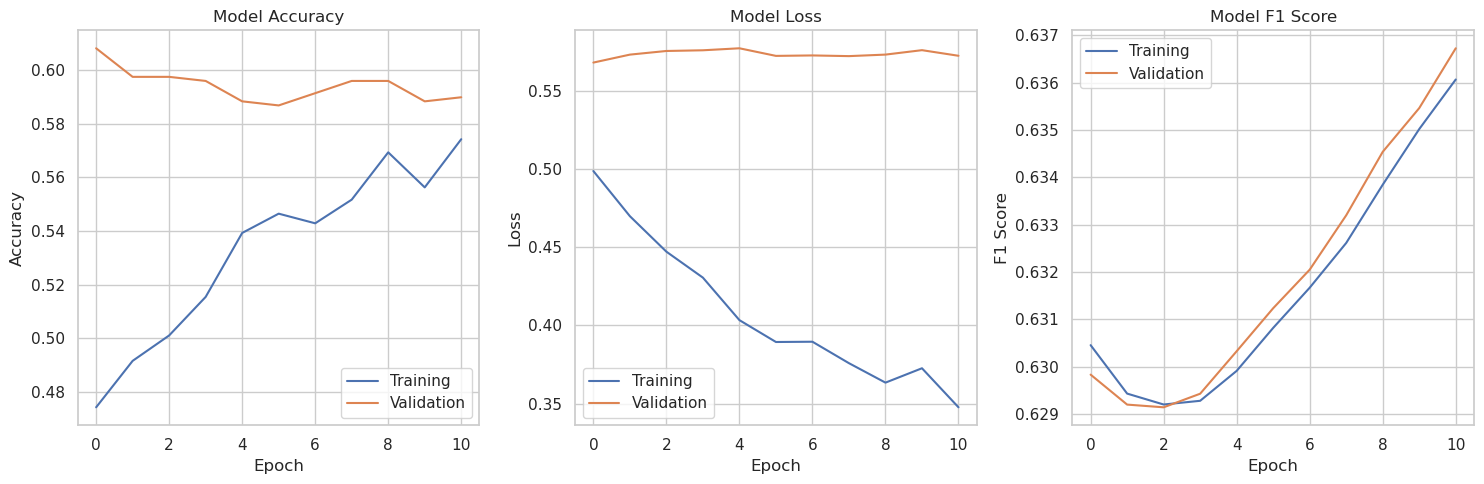

In [223]:
plot_history_subplot(history)

Test set distribution: Counter({0: 158, 5: 97, 3: 95, 4: 88, 2: 82, 6: 78, 1: 58})
Prediction distribution: Counter({6: 213, 5: 106, 3: 105, 2: 69, 4: 69, 1: 59, 0: 35})


/tmp/ipykernel_81362/937589467.py:65: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


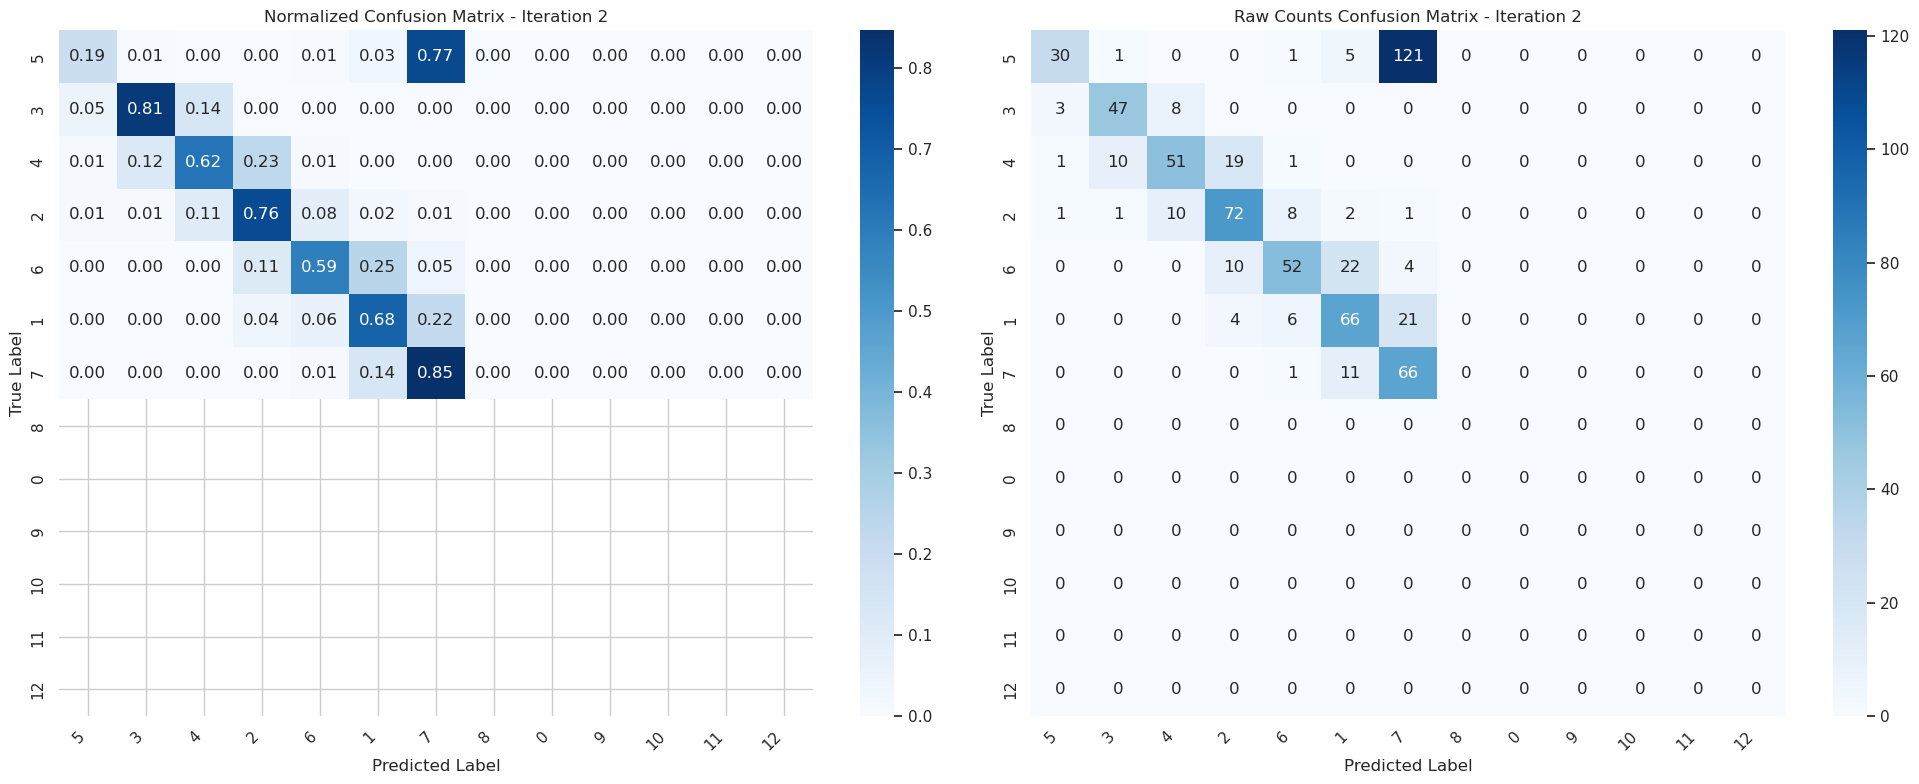

In [224]:
evaluation_results = evaluator.evaluate_iteration(
    iteration=2, test_ds=test_gen, class_names=all_classes
)

In [225]:
evaluator.print_classification_report(iteration=2)


Classification Report - Iteration 2
------------------------------------------------------------
5:::::::::::::: Precision: 0.857  Recall: 0.190  F1-score: 0.311
3:::::::::::::: Precision: 0.797  Recall: 0.810  F1-score: 0.803
4:::::::::::::: Precision: 0.739  Recall: 0.622  F1-score: 0.675
2:::::::::::::: Precision: 0.686  Recall: 0.758  F1-score: 0.720
6:::::::::::::: Precision: 0.754  Recall: 0.591  F1-score: 0.662
1:::::::::::::: Precision: 0.623  Recall: 0.680  F1-score: 0.650
7:::::::::::::: Precision: 0.310  Recall: 0.846  F1-score: 0.454
8:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
0:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
9:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
10::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
11::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
12::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
---------------------------------------------------------

## Train Iteratively


In [226]:
def train_iteratively(
    initial_class_count=7, final_classes_count=13, classes_per_iteration=2
):
    classes_trained = initial_class_count
    iteration = 1

    while classes_trained <= final_classes_count:
        print(f"Iteration: {iteration}")
        current_classes = dataset_manager.get_class_subset(num_classes=classes_trained)

        if iteration > 1:
            new_classes = current_classes[classes_trained - classes_per_iteration :]

            print(
                f"Previous classes: {current_classes[:classes_trained - classes_per_iteration]}"
            )
            print(f"New classes: {new_classes}")

        data_split = dataset_manager.prepare_data_split(current_classes)
        train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

        total_samples = sum(
            dataset_manager.class_counts[cls] for cls in current_classes
        )
        max_count = max(dataset_manager.class_counts[cls] for cls in current_classes)
        class_weights = {
            data_split.class_mapping[cls]: (
                total_samples / dataset_manager.class_counts[cls]
            )
            * (max_count / dataset_manager.class_counts[cls])
            for cls in current_classes
        }

        if iteration == 1:
            model = model_manager.build_model(len(current_classes))

        else:
            model_manager.prepare_next_iteration(
                previous_iteration=iteration - 1, new_num_classes=len(current_classes)
            )

        history = model_manager.train(
            train_gen,
            val_gen,
            iteration=iteration,
            epochs=100,
            class_weights=class_weights,
        )

        plot_history_subplot(history)
        evaluation_results = evaluator.evaluate_iteration(
            iteration=iteration, test_ds=test_gen, class_names=current_classes
        )

        evaluator.print_classification_report(iteration=iteration)
        classes_trained += classes_per_iteration
        iteration += 1

        if iteration > 2:
            compare_iterations_performance(evaluator, [iteration - 2, iteration - 1])

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Split sizes - Train: 2559, Val: 549, Test: 549
INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
Name: count, dtype: int64


Iteration: 1
Epoch 1/100
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6143 - loss: 5.2831 - sparse_f1_score: 0.6371
Epoch 1: val_accuracy improved from -inf to 0.52641, saving model to saved_models/best_model_iter_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.6145 - loss: 5.2767 - sparse_f1_score: 0.6371 - val_accuracy: 0.5264 - val_loss: 0.8599 - val_sparse_f1_score: 0.6376 - learning_rate: 1.0000e-04
Epoch 2/100
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6323 - loss: 4.7492 - sparse_f1_score: 0.6378
Epoch 2: val_accuracy did not improve from 0.52641
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6322 - loss: 4.7508 - sparse_f1_score: 0.6378 - val_accuracy: 0.5191 - val_loss: 0.8623 - val_sparse_f1_score: 0.6385 - learning_rate: 1.0000e-04
Epoch 3/100
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6607 - loss: 4.4111 - sparse_f1_score: 0.6389
Epoch 3: val_accuracy did not improve from 0.52641
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step -

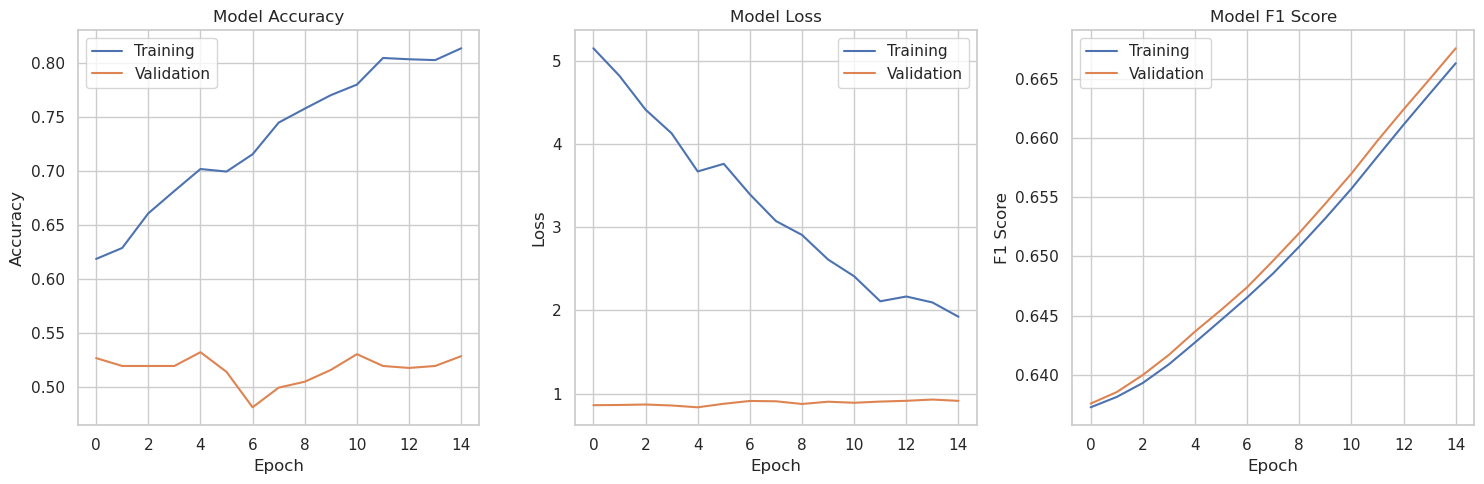

Test set distribution: Counter({5: 97, 3: 95, 4: 88, 2: 82, 6: 78, 1: 58, 0: 51})
Prediction distribution: Counter({6: 124, 4: 102, 5: 96, 2: 85, 3: 83, 1: 59})


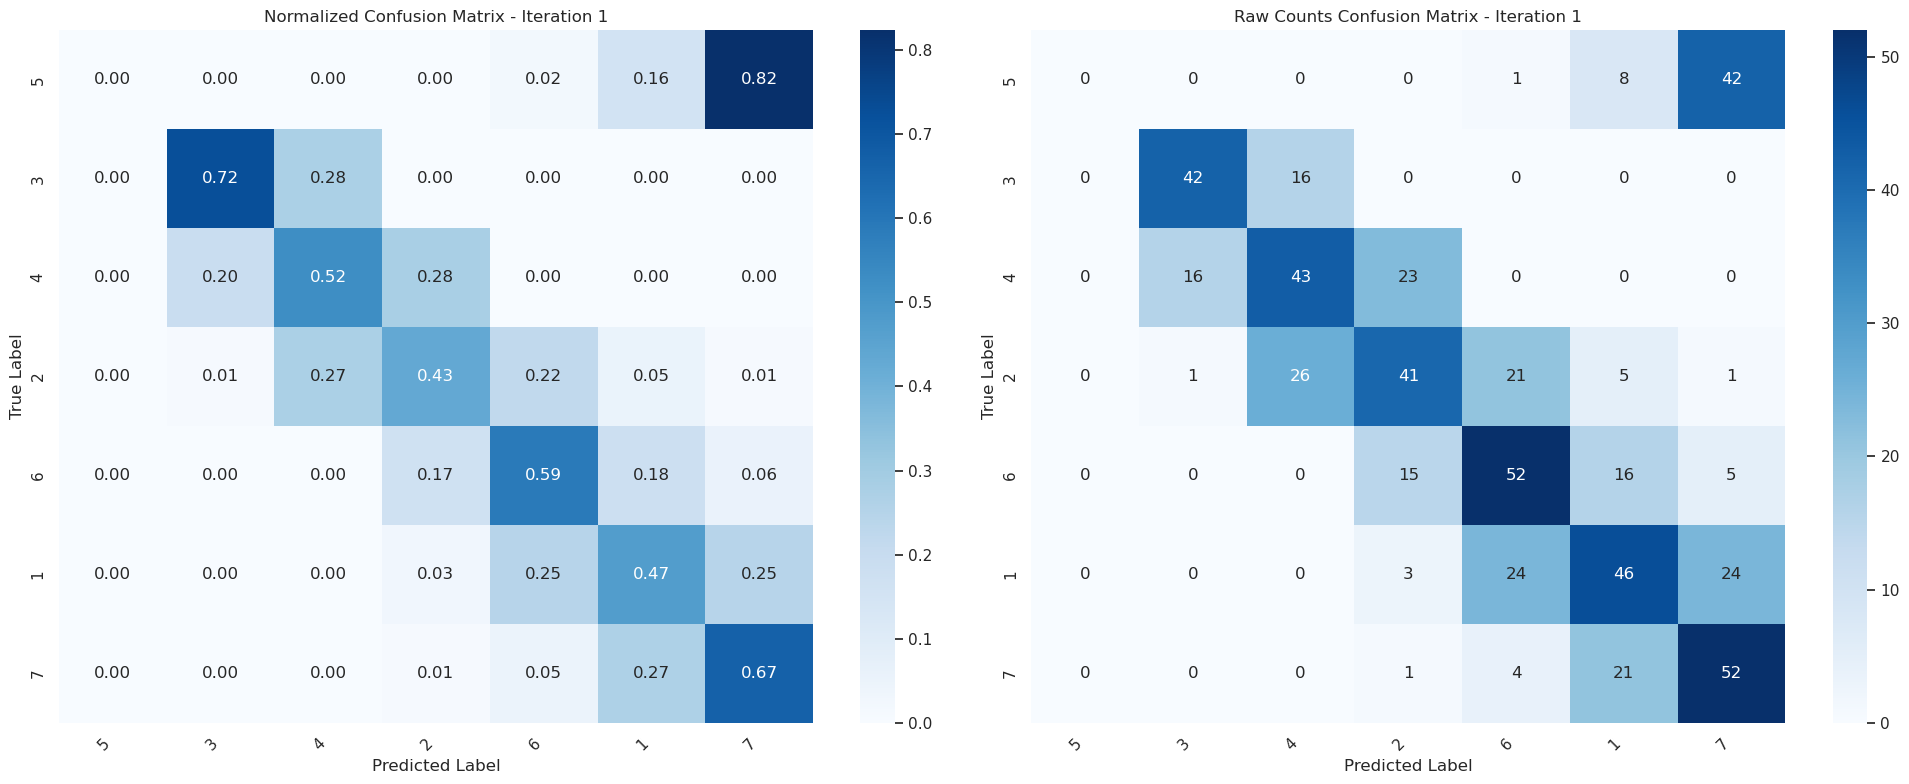

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Collected 241 images for class 8
INFO:__main__:Collected 206 images for class 0
INFO:__main__:Split sizes - Train: 2872, Val: 616, Test: 616
INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
8    169
0    144
Name: count, dtype: int64



Classification Report - Iteration 1
------------------------------------------------------------
5:::::::::::::: Precision: 0.000  Recall: 0.000  F1-score: 0.000
3:::::::::::::: Precision: 0.712  Recall: 0.724  F1-score: 0.718
4:::::::::::::: Precision: 0.506  Recall: 0.524  F1-score: 0.515
2:::::::::::::: Precision: 0.494  Recall: 0.432  F1-score: 0.461
6:::::::::::::: Precision: 0.510  Recall: 0.591  F1-score: 0.547
1:::::::::::::: Precision: 0.479  Recall: 0.474  F1-score: 0.477
7:::::::::::::: Precision: 0.419  Recall: 0.667  F1-score: 0.515
------------------------------------------------------------
Accuracy: 0.503
F1-Score: 0.462
Weighted F1-Score: 0.478
Iteration: 2
Previous classes: ['5', '3', '4', '2', '6', '1', '7']
New classes: ['8', '0']


AttributeError: 'ModelManager' object has no attribute 'sparse_f1_score'

In [227]:
train_iteratively(
    initial_class_count=7, final_classes_count=13, classes_per_iteration=2
)